In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import display
from datetime import timedelta
from sklearn import metrics 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

**Описание проекта:** в проекте исследуется структура активности пользователей мобильного приложения и на ее основе выделяются группы пользователей, для каждой из которых подсчитываются целевые метрики, анализируются причины различий в метриках между группами и предлагаются рекомендации по улучшению метрик. 
 
**Цель проекта:** 
1. Сегментировать пользователей на группы на основе поведения в приложении;
2. Провести статистический анализ различий между выделенными группами пользователей по целевым метрикам;
3. Сформировать типичные портреты клиентов. 

**Описание данных.**

Дафрейм mobile_dataset.csv:
- event.time — время совершения
- event.name — название события
- user.id — идентификатор пользователя

Датафрейм mobile_sources.csv:
- userId — идентификатор пользователя
- source — источник, с которого пользователь установил приложение

### Содержание

<a href='#step1'>Шаг 1. Предобработка данных </a>

<a href='#step2'>Шаг 2. Исследовательский анализ и работа с метриками </a>

<a href='#step3'>Шаг 3. Сегментация пользователей </a>

<a href='#step4'>Шаг 4. Статистический анализ данных</a>

<a href='#step5'>Шаг 5. Описание результатов и выводы</a>

<a id='step1'></a>
## Предобработка данных

**Сохранение данных в датафрейм**

In [2]:
dataset = pd.read_csv('')
sources = pd.read_csv('')

In [3]:
data = pd.merge(dataset, sources, how='left', left_on='user.id', right_on='userId').drop('userId', axis=1)

In [4]:
data.sample(5)

,event.time,event.name,user.id,source
21307,2019-10-15 21:57:01.818297,search_5,b5989ef9-d4fb-469c-9e38-313a33f307e3,yandex
3988,2019-10-08 16:01:25.086582,favorites_add,9ce63488-758a-481a-bcb5-a02b467e1d84,yandex
31007,2019-10-19 17:50:47.848265,advert_open,2561e4bb-a650-4009-bfc5-24632955b8b2,google
64159,2019-10-31 04:19:02.205127,tips_show,20436f39-6741-4e02-97a3-24899593b549,other
9836,2019-10-11 12:09:25.591570,tips_show,68c94835-e896-4d48-a2c0-3c3226cec629,yandex


**Унификация названий и значений колонок, проверка на наличие пропущенных значений**

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 4 columns):
event.time    74197 non-null object
event.name    74197 non-null object
user.id       74197 non-null object
source        74197 non-null object
dtypes: object(4)
memory usage: 2.8+ MB


In [6]:
data.columns = ['event_time', 'event_name', 'user_id', 'source']

In [7]:
data['source'].unique()

array(['other', 'yandex', 'google'], dtype=object)

In [8]:
data['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

Видим, что одно событие "Показать контакты" имеет два названия, "show_contacts" и "cotacts_show". Исправляем.

In [9]:
data.loc[data['event_name'] == 'contacts_show', 'event_name'] = 'show_contacts'

Все значения в колонках датафрейма представлены в одном формате.

In [10]:
len(data['user_id'].unique())

4293

**Изменение типов данных**

In [11]:
data['event_time'] = pd.to_datetime(data['event_time'], format='%Y-%m-%d %H:%M:%S').astype('datetime64[s]')

In [12]:
data = data.drop_duplicates().reset_index(drop=True)

**Генерация признаков**

Все регистрируемые действия, связанные с поиском, насколько известно, являются составными элементами одной общей активности, объединяем их

In [13]:
data.loc[data.event_name.str.contains('search'), 'event_name'] = 'search'

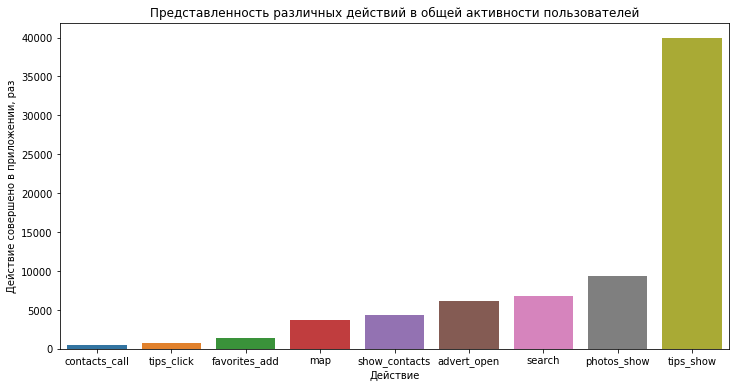

In [14]:
event_barplot = data['event_name'].value_counts().sort_values()
plt.figure(figsize=(12,6))
sns.barplot(x = event_barplot.index, y = event_barplot)
plt.xlabel('Действие')
plt.ylabel('Действие совершено в приложении, раз')
plt.title('Представленность различных действий в общей активности пользователей')
plt.show()

Смотрим, как активность меняется со временем суток

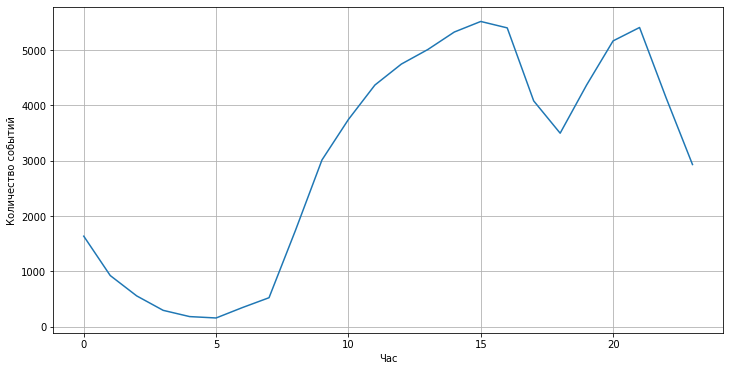

In [15]:
warnings.filterwarnings(action='ignore')

data['hour'] = data['event_time'].dt.hour
actions_by_hour = data.groupby('hour')['event_name'].count()
plt.figure(figsize=(12,6))
sns.lineplot(x=actions_by_hour.index, y=actions_by_hour)
plt.ylabel('Количество событий')
plt.xlabel('Час')
plt.grid()
plt.show()

Пробуем выделить признаки на основе времени. 

Создаем новую колонку в датафрейме, в нее записываем, в какое время суток было совершено действие (ночь/утро/день/вечер).

In [16]:
conditions = [(data.hour >= 0) & (data.hour < 6), 
              (data.hour >= 6) & (data.hour < 12), 
              (data.hour >= 12) & (data.hour < 18), 
              (data.hour >= 18) & (data.hour < 24)]
cat_values = ['night', 'morning', 'day', 'evening']
data['time_of_day'] = pd.Series(np.select(conditions, cat_values), index=data.index)

One-hot encoding колонок с информацией о событии, источнике и времени суток.

In [17]:
dummie_features = pd.get_dummies(data[['event_name', 'source', 'time_of_day']])

Подготавливаем датафрейм с описанием пользователей. Сопоставляем датафрейм с дамми-признаками с информацией об идентификторах пользователей, совершивщих действие, группируем получившийся датафрейм по user_id и находим среднее по каждой колонке (получаем, какую долю от общей активности у каждого пользователя составляет каждое действие, с какого источника он пришел, в какое время суток предпочитает пользоваться приложением).

In [18]:
prep_data = pd.merge(data['user_id'], dummie_features, left_on=data.index, right_on=dummie_features.index)
prep_data = prep_data.drop('key_0', axis=1)

In [19]:
prep_data = prep_data.groupby('user_id').mean()

In [20]:
prep_data

,event_name_advert_open,event_name_contacts_call,event_name_favorites_add,event_name_map,event_name_photos_show,event_name_search,event_name_show_contacts,event_name_tips_click,event_name_tips_show,source_google,source_other,source_yandex,time_of_day_day,time_of_day_evening,time_of_day_morning,time_of_day_night
user_id,,,,,,,,,,,,,,,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.000000,0.000000,0.000000,0.171429,0.000000,0.000000,0.000000,0.0,0.828571,0.0,1.0,0.0,0.257143,0.514286,0.228571,0.000000
00157779-810c-4498-9e05-a1e9e3cedf93,0.028169,0.070423,0.028169,0.000000,0.464789,0.253521,0.154930,0.0,0.000000,0.0,0.0,1.0,0.014085,0.661972,0.323944,0.000000
00463033-5717-4bf1-91b4-09183923b9df,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.000000
004690c3-5a84-4bb7-a8af-e0c8f8fca64e,0.156250,0.000000,0.000000,0.187500,0.000000,0.531250,0.000000,0.0,0.125000,1.0,0.0,0.0,0.156250,0.656250,0.000000,0.187500
00551e79-152e-4441-9cf7-565d7eb04090,0.000000,0.375000,0.000000,0.000000,0.125000,0.125000,0.375000,0.0,0.000000,0.0,0.0,1.0,0.875000,0.000000,0.000000,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,0.000000,0.000000,0.000000,0.117647,0.000000,0.000000,0.000000,0.0,0.882353,0.0,0.0,1.0,0.588235,0.411765,0.000000,0.000000
ffc01466-fdb1-4460-ae94-e800f52eb136,0.000000,0.000000,0.000000,0.000000,0.857143,0.000000,0.142857,0.0,0.000000,0.0,0.0,1.0,0.000000,1.000000,0.000000,0.000000
ffcf50d9-293c-4254-8243-4890b030b238,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.0,0.500000,1.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000


Подготоваливаем количественные признаки: среднее количество действий за сессию и количество сессий в приложении

Сортируем датафрейм по user_ud и event_time и создаем столбцы под новые данные

In [21]:
data = data.sort_values(by=['user_id', 'event_time']).reset_index(drop=True)
unique_users = data['user_id'].unique()

In [22]:
data['time_diff'] = pd.Series()
data['session'] = pd.Series()

Для каждого пользователя считаем, сколько времени прошло между каждой парой его ближайших во времени действий, и добавляем идентификаторы сессий (если между действиями пользователя прошло больше 30 минут -- считаем этот момент границей двух сессий).

In [23]:
session = 0
for user in unique_users:
    
    min_ix = data.loc[data['user_id'] == user].index.min()
    max_ix = data.loc[data['user_id'] == user].index.max()
    
    for i in range(min_ix, max_ix):
        data['time_diff'][i+1] = (data['event_time'][i+1] - data['event_time'][i]).total_seconds()
        
    for i in range(min_ix, max_ix+1):
        if data['time_diff'][i] < 1800 or pd.isnull(data['time_diff'][i]):
            data['session'][i] = session
        else:
            session += 1
            data['session'][i] = session
            
    session += 1

Смотрим на распределение продолжительности сессий

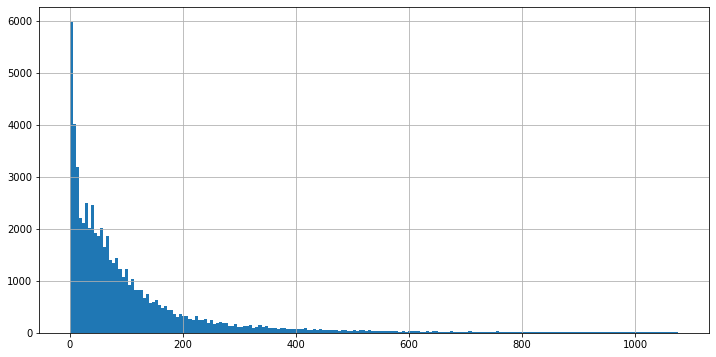

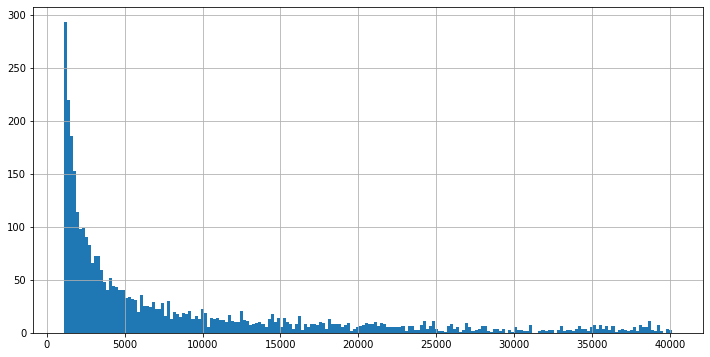

In [24]:
plt.figure(figsize=(12,6))
data['time_diff'].loc[data['time_diff'] < data['time_diff'].quantile(0.9)].hist(bins=200)
plt.show()
plt.figure(figsize=(12,6))
data['time_diff'].loc[(data['time_diff'] > data['time_diff'].quantile(0.9)) & (data['time_diff'] < data['time_diff'].quantile(0.95))].hist(bins=200)
plt.show()

In [25]:
data['time_diff'].describe()

count    6.876100e+04
mean     1.421358e+04
std      9.272077e+04
min      0.000000e+00
25%      2.600000e+01
50%      7.300000e+01
75%      1.840000e+02
max      2.296194e+06
Name: time_diff, dtype: float64

Считаем, сколько каждый пользователь совершает действий за каждую сессию и как много сессий у него было в приложении 

In [26]:
actions_by_session = data.groupby(['user_id', 'session'])['time_diff'].count()
actions_by_session.name = 'actions_by_session'
sessions_by_user = data.groupby('user_id')['session'].nunique()
sessions_by_user.name = 'sessions_by_user'

In [27]:
# Функция для удобного вывода гистограмм и описательных статистик по признакам и метрикам. На вход принимает  Series,
# по которой требуется построить гистограмму, строку-название для оформления вывода, квантиль, по которой исключаем выбросы,
# и количество корзин гистограммы

def feature_description(df, name, criterion=0.95, bins=25):
    print(name)
    print('')
    print(df.describe())
    outlier = int(df.quantile(criterion))
    df.loc[df < outlier].hist(bins=bins, figsize=(12,6))
    plt.title('Гистограмма распределения показателя' + ' ' + '"' + name + '"')
    plt.show()

Количество действий за сессию

count    10369.000000
mean         6.631401
std          9.353665
min          0.000000
25%          2.000000
50%          4.000000
75%          8.000000
max        148.000000
Name: actions_by_session, dtype: float64


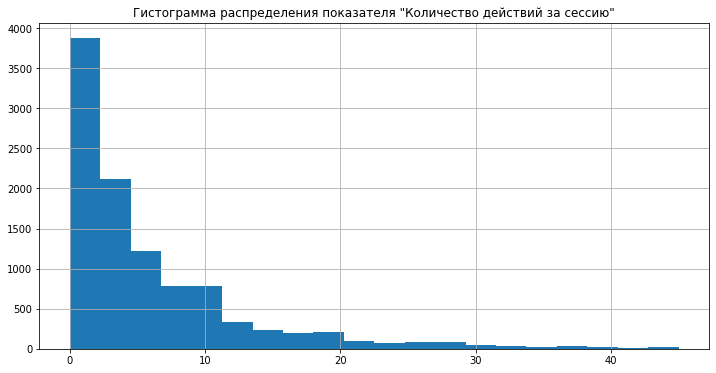

Количество сессий

count    4293.000000
mean        2.415327
std         3.536801
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        99.000000
Name: sessions_by_user, dtype: float64


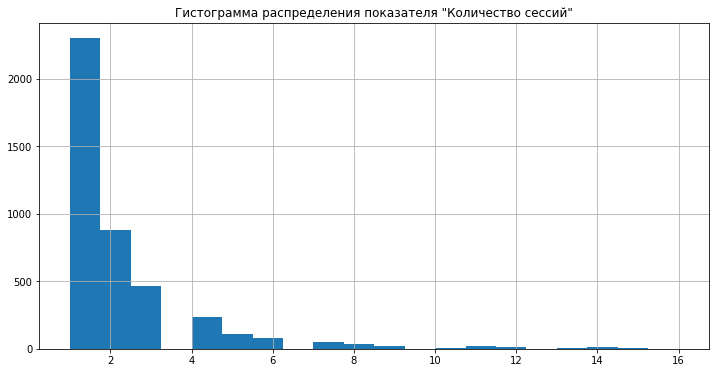

In [28]:
feature_description(actions_by_session, 'Количество действий за сессию', 0.99, 20)
feature_description(sessions_by_user, 'Количество сессий', 0.99, 20)

Добавляем данные о количестве сессий и действий за сессию в датафрейм с признаками

In [29]:
prep_data = pd.merge(prep_data, actions_by_session.groupby('user_id').mean(), on='user_id')
prep_data = pd.merge(prep_data, sessions_by_user, on='user_id')

Датафрейм для кластеризации готов: смотрим, что получилось

In [30]:
prep_data

,event_name_advert_open,event_name_contacts_call,event_name_favorites_add,event_name_map,event_name_photos_show,event_name_search,event_name_show_contacts,event_name_tips_click,event_name_tips_show,source_google,source_other,source_yandex,time_of_day_day,time_of_day_evening,time_of_day_morning,time_of_day_night,actions_by_session,sessions_by_user
user_id,,,,,,,,,,,,,,,,,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.000000,0.000000,0.000000,0.171429,0.000000,0.000000,0.000000,0.0,0.828571,0.0,1.0,0.0,0.257143,0.514286,0.228571,0.000000,8.500000,4
00157779-810c-4498-9e05-a1e9e3cedf93,0.028169,0.070423,0.028169,0.000000,0.464789,0.253521,0.154930,0.0,0.000000,0.0,0.0,1.0,0.014085,0.661972,0.323944,0.000000,11.666667,6
00463033-5717-4bf1-91b4-09183923b9df,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.000000,9.000000,1
004690c3-5a84-4bb7-a8af-e0c8f8fca64e,0.156250,0.000000,0.000000,0.187500,0.000000,0.531250,0.000000,0.0,0.125000,1.0,0.0,0.0,0.156250,0.656250,0.000000,0.187500,5.166667,6
00551e79-152e-4441-9cf7-565d7eb04090,0.000000,0.375000,0.000000,0.000000,0.125000,0.125000,0.375000,0.0,0.000000,0.0,0.0,1.0,0.875000,0.000000,0.000000,0.125000,2.333333,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,0.000000,0.000000,0.000000,0.117647,0.000000,0.000000,0.000000,0.0,0.882353,0.0,0.0,1.0,0.588235,0.411765,0.000000,0.000000,8.000000,2
ffc01466-fdb1-4460-ae94-e800f52eb136,0.000000,0.000000,0.000000,0.000000,0.857143,0.000000,0.142857,0.0,0.000000,0.0,0.0,1.0,0.000000,1.000000,0.000000,0.000000,6.000000,1
ffcf50d9-293c-4254-8243-4890b030b238,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.0,0.500000,1.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,1.000000,1


<a id='step2'></a>
## Исследовательский анализ и работа с метриками

**Рассчет продолжительности сессий**

Создаем два новых столбца: в один сохраняем время между действиями в рамках одной сессии, в другой -- время между сессиями.

In [31]:
data['time_between_actions'] = pd.Series()
data.loc[data['time_diff'] < 1800, 'time_between_actions'] = data['time_diff']
data['time_between_sessions'] = pd.Series()
data.loc[data['time_diff'] > 1800, 'time_between_sessions'] = data['time_diff']

Вычисляем продолжительность сессий, суммируя прошедшие между действиями в рамках одной сессии временные интервалы

In [32]:
session_duration = data.groupby(['user_id', 'session'])['time_between_actions'].sum()
session_duration.name = 'session_duration'
data = data.merge(session_duration, on='session')

Продолжительность сессии

count    10369.000000
mean       772.424824
std       1190.533367
min          0.000000
25%         21.000000
50%        335.000000
75%       1046.000000
max      19319.000000
Name: session_duration, dtype: float64


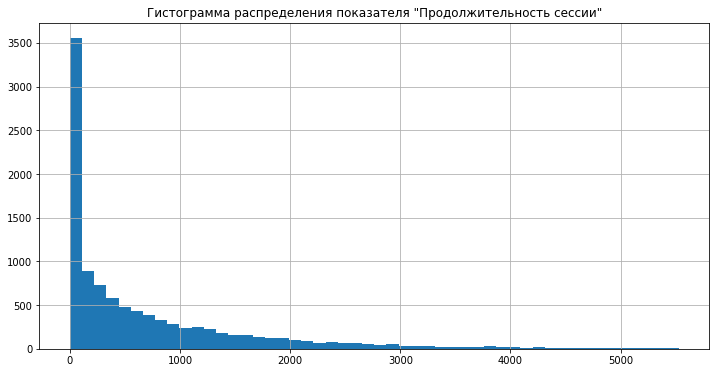

In [33]:
feature_description(session_duration, 'Продолжительность сессии', 0.99, 50)

Видим несколько особенностей: во-первых, много сессий с нулевой длительностью (на деле это сессии, состоявшие из одного действия), плюс несколько сессий, длившихся больше нескольких часов. Необходимо будет принять решение, как их обрабатывать.

In [34]:
session_duration_by_user = session_duration.groupby('user_id').mean()
mean_session_duration = session_duration.groupby('session').mean().mean()
mean_session_duration

772.4248239945993

**Рассчет retention rate**

Смотрим на данные о том, сколько времени проходит между сессиями, и берем от этого времени 95% квантиль.

Время между сессиями

count    6.075000e+03
mean     1.595603e+05
std      2.722970e+05
min      1.801000e+03
25%      7.960500e+03
50%      6.099300e+04
75%      1.727720e+05
max      2.296194e+06
Name: time_between_sessions, dtype: float64


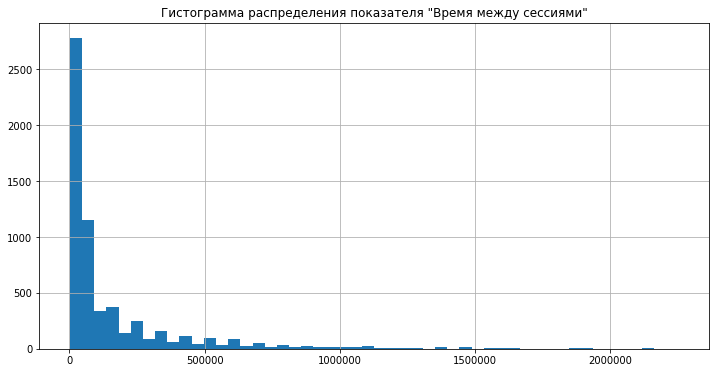

In [35]:
feature_description(data['time_between_sessions'], 'Время между сессиями', 1, 50)

In [36]:
data['time_between_sessions'].quantile(0.85) / 60 / 60 / 24

3.8845150462962947

85% временных интервалов между сессиями меньше 3 дней. 3 дня возьмем за критерий, в соответствии с которым будем определять факт оттока пользователей. Если в последний раз пользователь заходил в приложение раньше, чем за 8 дней до даты последней записи в наших данных, считаем, что он перестал пользоваться приложением. 

In [37]:
date_criterion = data['event_time'].max() - timedelta(days=3)

Проверяем, какие пользователи выполнили свое последнее действие в приложении раньше, чем определенная нами дата-критерий, и добавляем эти данные в исходный датафрейм

In [38]:
is_inactive = data.groupby('user_id')['event_time'].max() < date_criterion
is_inactive.name = 'is_inactive'

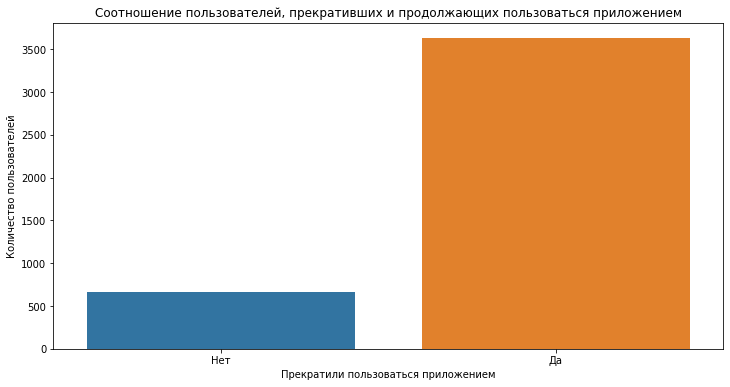

In [39]:
inactive_barplot = is_inactive.value_counts().sort_values()
inactive_barplot.index = ['Нет', 'Да']
plt.figure(figsize=(12,6))
sns.barplot(x = inactive_barplot.index, y = inactive_barplot)
plt.xlabel('Прекратили пользоваться приложением')
plt.ylabel('Количество пользователей')
plt.title('Соотношение пользователей, прекративших и продолжающих пользоваться приложением')
plt.show()

In [40]:
data = data.merge(is_inactive, on='user_id')

Вычисляем retention rate (сколько пользователей продолжают пользоваться приложением) по выборке в целом.

In [41]:
retention_rate = 1 - is_inactive.mean()
retention_rate

0.15490333100395992

15.5% пользователей продолжают пользоваться приложением (заходили в приложение меньше чем за 8 дней до последней даты в исследуемых данных).

Добавим к retention rate поправку на тех пользователей, которые впервые зашли в приложение в течение последних 8 дней.

In [42]:
len(sessions_by_user.loc[(sessions_by_user == 1)]) / len(sessions_by_user)

0.5357558816678314

Приблизительно половина всех пользователей заходит в приложение только один раз.

In [43]:
last3days_users = data.groupby('user_id')['event_time'].min() > date_criterion
last3days_users = last3days_users.loc[last3days_users == 1].index

In [44]:
data['is_new'] = pd.Series()
data.loc[data['user_id'].isin(last3days_users), 'is_new'] = 1
data['is_new'] = data['is_new'].fillna(0)

In [45]:
last3days_users_sessions = data.query('user_id in @last3days_users').groupby('user_id')['session'].nunique()
new_users = len(last3days_users_sessions.loc[last3days_users_sessions == 1])

Теперь мы выяснили, что 621 пользователь из тех, кто зарегестрировался в течение последних 8 дней, заходил в приложение только однажды. Примерно половина из них -- 310 человек -- вероятно, не зайдут в приложение больше никогда. 

In [46]:
new_users / 2 / len(prep_data)

0.029117167481947356

Что составляет чуть больше 7 процентов от общего числа пользователей. На эти 2.7% необходимо скорректировать посчитанный Retention Rate.

In [47]:
retention_rate_corrected = retention_rate - 0.027
retention_rate_corrected

0.12790333100395992

**Рассчет частоты действий**

Вычисляем, как много действий было совершено во время каждой сессии, и делим на продолжительность сессии. Затем усредняем получившиеся значения по пользователям. 

In [48]:
actions_per_second_by_session = data.groupby(['user_id', 'session'])['event_name'].count() / data.groupby(['user_id', 'session'])['session_duration'].mean()
actions_per_second_by_session = actions_per_second_by_session.replace(np.inf, np.nan)
actions_per_second_by_session.name = 'actions_per_second_by_session'
actions_per_second_by_user = actions_per_second_by_session.groupby('user_id').mean()
actions_per_second_by_user.name = 'actions_per_second'

In [49]:
mean_actions_per_second = actions_per_second_by_session.mean()
mean_actions_per_second

0.0450757276740261

В среднем пользователи приложения совершают 4.5 действия каждые 100 секунд или одно действие каждые 22.5 секунды.

**Рассчет конверсии**

Находим сессии, во время которых было совершено целевое действие, в исходном датафрейме создаем столбец и отмечаем в нем эти сессии.

In [50]:
sessions_with_target = data.loc[data['event_name'] == 'show_contacts']['session'].unique()
data['target_session'] = pd.Series()
data.loc[data['session'].isin(sessions_with_target), 'target_session'] = 1

In [51]:
data['target_session'] = data['target_session'].fillna(0)

Обобщаем до уровня пользователей: определяем, какие пользователи хотя бы раз совершили целевое действие за время пользования приложением.

In [52]:
is_target_action = data.groupby('user_id')['target_session'].mean()

In [53]:
is_target_action = np.ceil(is_target_action)

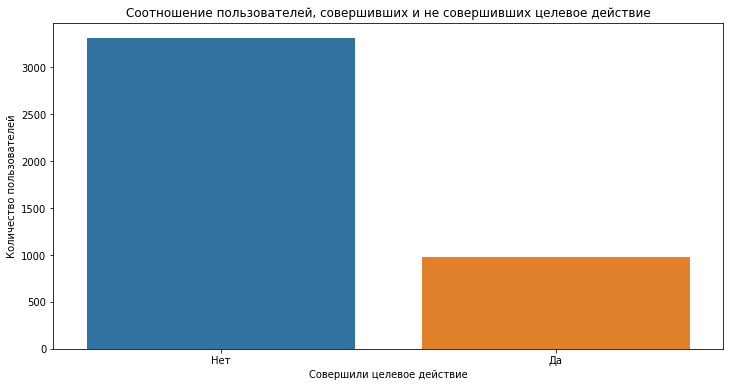

In [54]:
target_barplot = is_target_action.value_counts()
target_barplot.index = ['Нет', 'Да']
plt.figure(figsize=(12,6))
sns.barplot(x=target_barplot.index, y = target_barplot)
plt.xlabel('Совершили целевое действие')
plt.ylabel('Количество пользователей')
plt.title('Соотношение пользователей, совершивших и не совершивших целевое действие')
plt.show()

In [55]:
conversion = target_barplot[1] / (target_barplot[0] + target_barplot[1])
conversion

0.22851153039832284

<div class="alert alert-success">
<b>Комментарий наставника:</b> Все верно. Конверсия довольно маленькая.</div>

Собираем все данные по метрикам в один датафрейм

In [56]:
actions_per_second_by_session.name = 'actions_per_second'
users_metrics = pd.merge(session_duration.reset_index(), is_inactive, on='user_id')
users_metrics = pd.merge(users_metrics, actions_per_second_by_session, on=['user_id', 'session'])
users_metrics = pd.merge(users_metrics, is_target_action, on='user_id')

In [57]:
users_metrics['is_inactive'] = users_metrics['is_inactive'].astype('int')
users_metrics  = users_metrics.rename(columns={'target_session' : 'is_target'})
users_metrics['is_target'] = users_metrics['is_target'].astype('int')

In [58]:
users_metrics

,user_id,session,session_duration,is_inactive,actions_per_second,is_target
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.0,596.0,1,0.015101,0
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1.0,507.0,1,0.007890,0
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2.0,900.0,1,0.015556,0
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3.0,758.0,1,0.010554,0
4,00157779-810c-4498-9e05-a1e9e3cedf93,4.0,1521.0,0,0.005917,1
...,...,...,...,...,...,...
10364,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10364.0,0.0,0,NaN,1
10365,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10365.0,974.0,0,0.002053,1
10366,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10366.0,297.0,0,0.013468,1
10367,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10367.0,949.0,0,0.015806,1


### Описание выборки

Больше всего пользователей пользуется приложением с 12 до 16 часов, меньше всего -- с 2 до 6 часов.

Чаще всего в приложении пользователи обращаются к справке (событие "tips_show", больше половины от общего числа событий), затем идут действия "показ фотографий" (событие "photos_show") и объединенные события, связанные с поиском ("search"). 

Медианное количество действий за сессию у пользователей 3, в 75% сессий совершается меньше 7 действий. Больше половины пользователей заходят в приложение только однажды.

### Метрики

Средняя продолжительность сессии по всем пользователям равна 12 минут, медианная -- 5 минут.

37% пользователей заходили в приложение в течение поледних 8 дней сбора данных, скорректированный Retention Rate = 29.7%.

В среднем, пользователи во время сессии совершают одно действие каждые 22.5 секунды.

Конверсия = 0.23. 23% пользователей хотя бы раз совершили целевое действие.

<a id='step3'></a>
## Сегментация пользователей

**Стандартизация данных**

In [59]:
scaler = StandardScaler()
data_for_clust = scaler.fit_transform(prep_data)

**Определение оптимального числа кластеров**

In [60]:
# Функция для подсчета внутрикластерной суммы квадратов ошибок. На вход принимает массив точек и максимальное количество
# кластеров, возвращает словарь со значениями внутрикластерной суммы квадратов ошибок для каждого числа кластеров.

# Работает следующим образом: берет все значения k в заданном диапазоне, кластеризует данные на данное число кластеров 
# (для каждого числа кластеров кластеризация выполняется несколько раз, чтобы нивеллировать фактор неудачной инициализаци)
# центройдов) и высчитывает расстояние от каждой точки каждого кластера до центройдов их кластеров, а затем суммирует их
# (это и есть WSS -- внутрикластерная сумма квадратов ошибок). Для каждого количества кластеров сохраняется наименьшая
# WSS.

def calculate_WSS(points, kmax):
    sse = {}
    curr_sse = 0
    for k in range(1, kmax+1):
        sse[k] = 1e10
        
        for n in range(6):
            kmeans = KMeans(n_clusters = k).fit(points)
            centroids = kmeans.cluster_centers_
            pred_clusters = kmeans.predict(points)
        
            for i in range(len(points)):
                curr_center = centroids[pred_clusters[i]]
                curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2

            if curr_sse < sse[k]:
                sse[k] = curr_sse
            
            curr_sse = 0
        
    return sse

In [61]:
sse = calculate_WSS(data_for_clust, 20)

In [62]:
for key,val in sse.items(): 
    print(str(key)+' : '+str(val)) 

1 : 8586.000000000142
2 : 8112.293939530163
3 : 8057.739912376231
4 : 6175.114627286565
5 : 3252.5018094334923
6 : 6086.04962601883
7 : 3229.836382257396
8 : 3442.6804674394743
9 : 3574.9792102825163
10 : 2489.122860482439
11 : 2538.1412304252735
12 : 2545.6571864734196
13 : 2502.643893854632
14 : 2489.3370226713664
15 : 2485.0895538301797
16 : 2425.771082884709
17 : 2581.986007947085
18 : 2528.8437570179403
19 : 2542.573237779613
20 : 2611.2285775019327


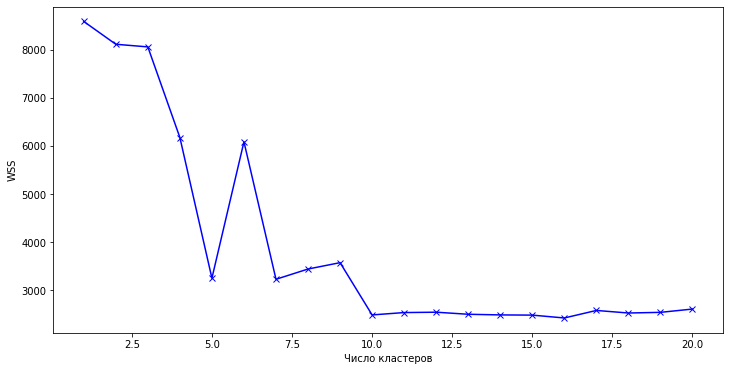

In [63]:
plt.figure(figsize=(12,6))
plt.plot(list(sse.keys()), list(sse.values()), 'bx-') 
plt.xlabel('Число кластеров') 
plt.ylabel('WSS') 
plt.show() 

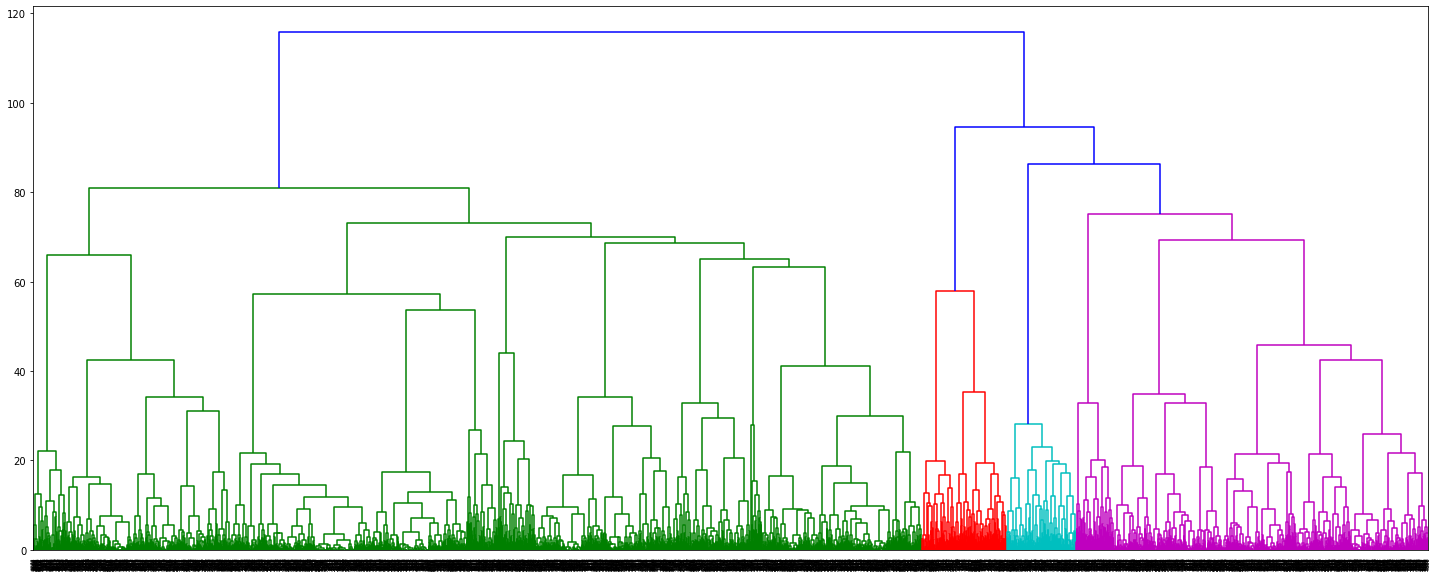

In [64]:
dist = linkage(data_for_clust, method='ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(dist, orientation='top')
plt.show()

Также попробуем кластеризовать только на основании данных о действиях.

In [65]:
data_for_clust_act = data_for_clust[:,0:10]

In [66]:
sse2 = calculate_WSS(data_for_clust_act, 20)

In [67]:
for key,val in sse2.items(): 
    print(str(key)+' : '+str(val)) 

1 : 8586.000000000142
2 : 8105.134394451804
3 : 6227.6756097929
4 : 3153.104042572712
5 : 2919.6178203116538
6 : 1911.9443609793693
7 : 2860.4753025485734
8 : 3248.093668961143
9 : 1994.3957275894381
10 : 1980.910525868959
11 : 1975.9155210406311
12 : 1400.250541790102
13 : 1407.2645337309555
14 : 971.76836011894
15 : 956.8944266361774
16 : 926.0191416740778
17 : 924.5305800977015
18 : 877.4146463588343
19 : 785.8976751928279
20 : 775.7354762916859


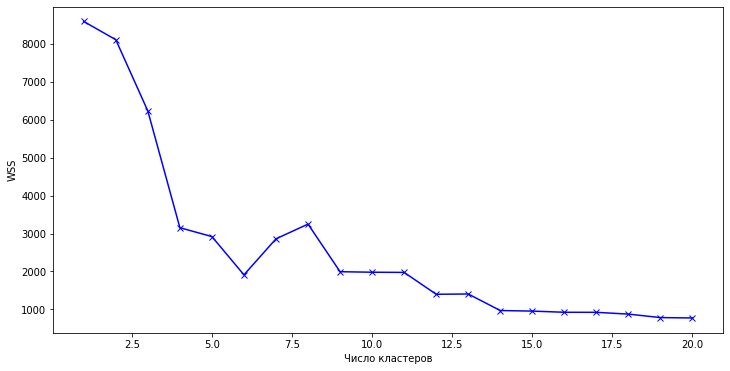

In [68]:
plt.figure(figsize=(12,6))
plt.plot(list(sse2.keys()), list(sse2.values()), 'bx-') 
plt.xlabel('Число кластеров') 
plt.ylabel('WSS') 
plt.show() 

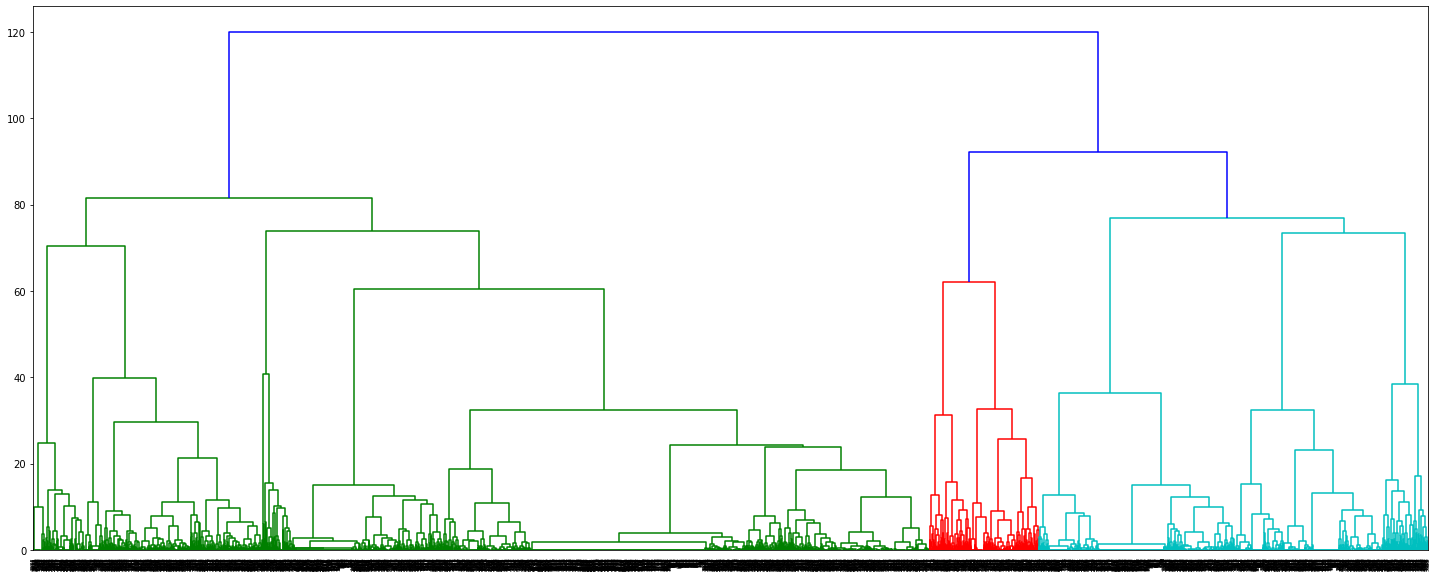

In [69]:
dist2 = linkage(data_for_clust_act, method='ward')
fig = plt.figure(figsize=(25, 10))
dn2 = dendrogram(dist2, orientation='top')
plt.show()

И данные с дополнительными признаками, и данные только с признаками-действиями, хорошо описываются 4 кластерами (для этого числа кластеров наблюдается резкое уменьшение WSS). При этом для данных с дополнительными признаками еще один такой скачок WSS наблюдается для 8 кластеров. Сохраним все варианты и посмотрим на них внимательнее.

In [70]:
kmeans_full_4 = KMeans(n_clusters=4, random_state=0).fit(data_for_clust)
full_4_pred_clusters = kmeans_full_4.predict(data_for_clust)
full_4_centroids = kmeans_full_4.cluster_centers_

curr_sse = 0

for i in range(len(data_for_clust)):
    curr_center = full_4_centroids[full_4_pred_clusters[i]]
    curr_sse += (data_for_clust[i, 0] - curr_center[0]) ** 2 + (data_for_clust[i, 1] - curr_center[1]) ** 2

curr_sse

6207.406453587086

In [71]:
kmeans_full_8 = KMeans(n_clusters=8, random_state=0).fit(data_for_clust)
full_8_pred_clusters = kmeans_full_8.predict(data_for_clust)
full_8_centroids = kmeans_full_8.cluster_centers_

curr_sse = 0

for i in range(len(data_for_clust)):
    curr_center = full_8_centroids[full_8_pred_clusters[i]]
    curr_sse += (data_for_clust[i, 0] - curr_center[0]) ** 2 + (data_for_clust[i, 1] - curr_center[1]) ** 2

curr_sse

3435.2614730052574

In [72]:
kmeans_act_4 = KMeans(n_clusters=4, random_state=2).fit(data_for_clust_act)
act_4_pred_clusters = kmeans_act_4.predict(data_for_clust_act)
act_4_centroids = kmeans_act_4.cluster_centers_

curr_sse = 0

for i in range(len(data_for_clust)):
    curr_center = act_4_centroids[act_4_pred_clusters[i]]
    curr_sse += (data_for_clust_act[i, 0] - curr_center[0]) ** 2 + (data_for_clust_act[i, 1] - curr_center[1]) ** 2

curr_sse

3153.104042572712

In [73]:
clusters = pd.DataFrame(prep_data.index)

In [74]:
clusters['full_4'] = full_4_pred_clusters
clusters['act_4'] = act_4_pred_clusters
clusters['full_8'] = full_8_pred_clusters

In [75]:
clusters

,user_id,full_4,act_4,full_8
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,1,3
1,00157779-810c-4498-9e05-a1e9e3cedf93,2,0,1
2,00463033-5717-4bf1-91b4-09183923b9df,2,0,1
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2,0,4
4,00551e79-152e-4441-9cf7-565d7eb04090,3,3,7
...,...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,0,1,2
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,2,0,1
4290,ffcf50d9-293c-4254-8243-4890b030b238,1,1,5
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,2,0,1


In [76]:
users_metrics = users_metrics.merge(clusters, on='user_id')

In [77]:
users_metrics

,user_id,session,session_duration,is_inactive,actions_per_second,is_target,full_4,act_4,full_8
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.0,596.0,1,0.015101,0,1,1,3
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1.0,507.0,1,0.007890,0,1,1,3
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2.0,900.0,1,0.015556,0,1,1,3
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3.0,758.0,1,0.010554,0,1,1,3
4,00157779-810c-4498-9e05-a1e9e3cedf93,4.0,1521.0,0,0.005917,1,2,0,1
...,...,...,...,...,...,...,...,...,...
10364,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10364.0,0.0,0,NaN,1,0,1,2
10365,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10365.0,974.0,0,0.002053,1,0,1,2
10366,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10366.0,297.0,0,0.013468,1,0,1,2
10367,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10367.0,949.0,0,0.015806,1,0,1,2


In [78]:
prep_data = prep_data.merge(clusters, on='user_id')
prep_data

,user_id,event_name_advert_open,event_name_contacts_call,event_name_favorites_add,event_name_map,event_name_photos_show,event_name_search,event_name_show_contacts,event_name_tips_click,event_name_tips_show,...,source_yandex,time_of_day_day,time_of_day_evening,time_of_day_morning,time_of_day_night,actions_by_session,sessions_by_user,full_4,act_4,full_8
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.000000,0.000000,0.000000,0.171429,0.000000,0.000000,0.000000,0.0,0.828571,...,0.0,0.257143,0.514286,0.228571,0.000000,8.500000,4,1,1,3
1,00157779-810c-4498-9e05-a1e9e3cedf93,0.028169,0.070423,0.028169,0.000000,0.464789,0.253521,0.154930,0.0,0.000000,...,1.0,0.014085,0.661972,0.323944,0.000000,11.666667,6,2,0,1
2,00463033-5717-4bf1-91b4-09183923b9df,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,...,1.0,1.000000,0.000000,0.000000,0.000000,9.000000,1,2,0,1
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,0.156250,0.000000,0.000000,0.187500,0.000000,0.531250,0.000000,0.0,0.125000,...,0.0,0.156250,0.656250,0.000000,0.187500,5.166667,6,2,0,4
4,00551e79-152e-4441-9cf7-565d7eb04090,0.000000,0.375000,0.000000,0.000000,0.125000,0.125000,0.375000,0.0,0.000000,...,1.0,0.875000,0.000000,0.000000,0.125000,2.333333,3,3,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,0.000000,0.000000,0.000000,0.117647,0.000000,0.000000,0.000000,0.0,0.882353,...,1.0,0.588235,0.411765,0.000000,0.000000,8.000000,2,0,1,2
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,0.000000,0.000000,0.000000,0.000000,0.857143,0.000000,0.142857,0.0,0.000000,...,1.0,0.000000,1.000000,0.000000,0.000000,6.000000,1,2,0,1
4290,ffcf50d9-293c-4254-8243-4890b030b238,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.0,0.500000,...,0.0,0.000000,0.000000,1.000000,0.000000,1.000000,1,1,1,5
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,0.000000,0.000000,0.000000,0.000000,0.538462,0.384615,0.076923,0.0,0.000000,...,1.0,0.461538,0.000000,0.538462,0.000000,4.000000,3,2,0,1


Исключаем из данных выбросы

In [79]:
users_metrics_clrd = users_metrics.loc[(users_metrics['session_duration'] < users_metrics['session_duration'].quantile(0.98)) & (
                                        users_metrics['actions_per_second'] < users_metrics['actions_per_second'].quantile(0.98))]

In [80]:
full_features = list(prep_data.iloc[:,1:21].columns)
act_features = list(prep_data.iloc[:,1:10].columns)

In [81]:
# Функция для удобного вывода описаний кластеров. 

def clusters_desciption(clusters, is_full_features = True):
    display(users_metrics_clrd.groupby(clusters)[['session_duration', 'actions_per_second']].median())
    display(users_metrics_clrd.groupby([clusters, 'user_id'])[['is_inactive', 'is_target']].mean().groupby(clusters).mean())
    if is_full_features:
        display(prep_data.groupby(clusters)[full_features].mean())
    else:
        display(prep_data.groupby(clusters)[act_features].mean())

In [82]:
clusters_desciption('full_4')

,session_duration,actions_per_second
full_4,,
0,648.0,0.012048
1,632.0,0.011757
2,409.0,0.011628
3,306.5,0.015465


,is_inactive,is_target
full_4,,
0,0.874368,0.187184
1,0.842038,0.173248
2,0.811973,0.213322
3,0.846154,1.000000


,event_name_advert_open,event_name_contacts_call,event_name_favorites_add,event_name_map,event_name_photos_show,event_name_search,event_name_show_contacts,event_name_tips_click,event_name_tips_show,source_google,source_other,source_yandex,time_of_day_day,time_of_day_evening,time_of_day_morning,time_of_day_night,actions_by_session,sessions_by_user,full_4,act_4
full_4,,,,,,,,,,,,,,,,,,,,
0,0.079039,0.000090,0.003668,0.093623,0.000642,0.063454,0.032862,0.012420,0.714201,0.218063,0.287225,0.494711,0.919443,0.031344,0.046941,0.002271,8.791370,2.170871,0.0,1.131001
1,0.082578,0.000047,0.004510,0.093022,0.000848,0.063525,0.029210,0.017839,0.708421,0.240025,0.301412,0.458564,0.065782,0.531265,0.339938,0.063015,8.856879,2.216697,1.0,1.159607
2,0.012261,0.003875,0.049072,0.002821,0.546263,0.333572,0.033674,0.000790,0.017671,0.330313,0.273476,0.396211,0.306604,0.448112,0.162347,0.082937,4.835312,2.921746,2.0,0.032125
3,0.001915,0.167529,0.016113,0.002168,0.155322,0.081998,0.556484,0.001131,0.017340,0.312217,0.244344,0.443439,0.522181,0.263151,0.191621,0.023047,4.715163,2.457014,3.0,2.864253


In [83]:
clusters_desciption('act_4', False)

,session_duration,actions_per_second
act_4,,
0,408.0,0.011628
1,674.0,0.010949
2,527.0,0.018634
3,310.0,0.016143


,is_inactive,is_target
act_4,,
0,0.816993,0.209150
1,0.855175,0.196801
2,0.847458,0.112288
3,0.852217,1.000000


,event_name_advert_open,event_name_contacts_call,event_name_favorites_add,event_name_map,event_name_photos_show,event_name_search,event_name_show_contacts,event_name_tips_click,event_name_tips_show
act_4,,,,,,,,,
0,0.008516,0.004188,0.045980,0.004024,0.530925,0.345290,0.034636,0.001692,0.024749
1,0.009603,0.000000,0.004233,0.090485,0.000483,0.051953,0.034607,0.017456,0.791180
2,0.443583,0.000468,0.008094,0.108781,0.007254,0.068422,0.011553,0.004673,0.347173
3,0.001968,0.169504,0.016563,0.004822,0.138557,0.080038,0.566321,0.001163,0.021065


In [84]:
clusters_desciption('full_8', True)

,session_duration,actions_per_second
full_8,,
0,561.0,0.019760
1,507.0,0.010651
2,670.0,0.011270
3,695.0,0.010582
4,283.0,0.013793
5,571.0,0.012146
6,433.5,0.013025
7,291.0,0.015748


,is_inactive,is_target
full_8,,
0,0.841935,0.119355
1,0.804444,0.220741
2,0.873393,0.211672
3,0.825677,0.183746
4,0.822034,0.171610
5,0.877698,0.196043
6,0.817073,0.170732
7,0.856410,1.000000


,event_name_advert_open,event_name_contacts_call,event_name_favorites_add,event_name_map,event_name_photos_show,event_name_search,event_name_show_contacts,event_name_tips_click,event_name_tips_show,source_google,source_other,source_yandex,time_of_day_day,time_of_day_evening,time_of_day_morning,time_of_day_night,actions_by_session,sessions_by_user,full_4,act_4
full_8,,,,,,,,,,,,,,,,,,,,
0,0.517434,0.000482,0.003791,0.078863,0.007337,0.049532,0.011287,0.005353,0.325921,0.247649,0.388715,0.363636,0.478642,0.349352,0.117960,0.054046,15.072407,2.385580,0.561129,1.990596
1,0.006983,0.004805,0.017341,0.000212,0.837606,0.099983,0.030984,0.000004,0.002082,0.294203,0.320290,0.385507,0.307224,0.467140,0.144629,0.081007,5.554348,3.152174,2.008696,0.008696
2,0.020142,0.000106,0.002378,0.095743,0.001616,0.045473,0.037925,0.014202,0.782415,0.214695,0.266221,0.519084,0.915802,0.034716,0.047065,0.002417,8.079566,2.269084,0.022901,1.037214
3,0.022163,0.000000,0.004592,0.086581,0.001386,0.055144,0.031858,0.021572,0.776704,0.250851,0.238365,0.510783,0.055126,0.832399,0.021152,0.091322,8.681703,2.263337,1.001135,1.054484
4,0.006014,0.003636,0.012968,0.016024,0.133187,0.722546,0.030459,0.002466,0.072700,0.362887,0.268041,0.369072,0.349919,0.425041,0.141101,0.083939,3.501915,2.468041,1.810309,0.076289
5,0.046094,0.000138,0.005982,0.103736,0.014877,0.075991,0.040889,0.013436,0.698857,0.229310,0.344828,0.425862,0.075228,0.019438,0.902077,0.003257,7.132061,1.975862,1.024138,1.072414
6,0.076197,0.008406,0.525346,0.001975,0.162203,0.142926,0.023225,0.008483,0.051238,0.317073,0.182927,0.500000,0.358507,0.354826,0.196359,0.090309,7.166981,2.487805,1.878049,0.317073
7,0.002662,0.172133,0.011729,0.002304,0.143904,0.083125,0.570425,0.001202,0.012517,0.317308,0.245192,0.437500,0.524207,0.269743,0.181562,0.024487,4.640816,2.471154,2.995192,2.927885


Видно, что в плане различия кластеров по метрикам самый интересный и контрастный вариант -- кластеризация пользователей только на основе действий на 4 кластера. Дальше будем работать только с ним.

Посмотрим на количество пользователей в каждом кластере.

Какая часть всех пользователей попала в каждый кластер

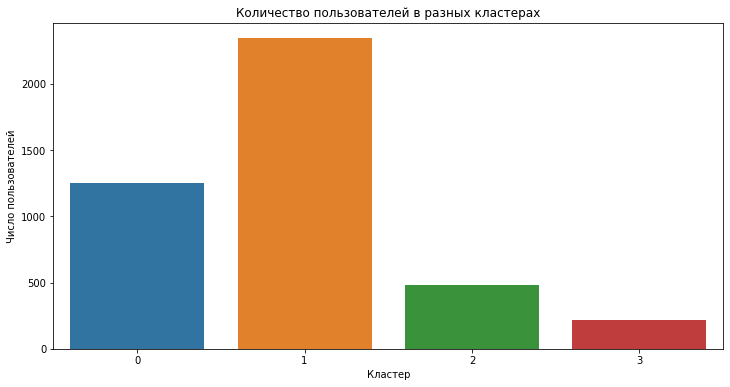

In [86]:
plt.figure(figsize=(12,6))
sns.barplot(x = n_users_in_clusters.index, y = n_users_in_clusters)
plt.xlabel('Кластер')
plt.ylabel('Число пользователей')
plt.title('Количество пользователей в разных кластерах')
plt.show()

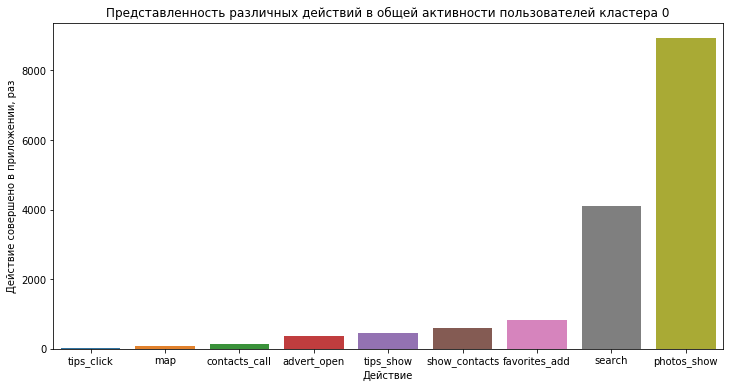

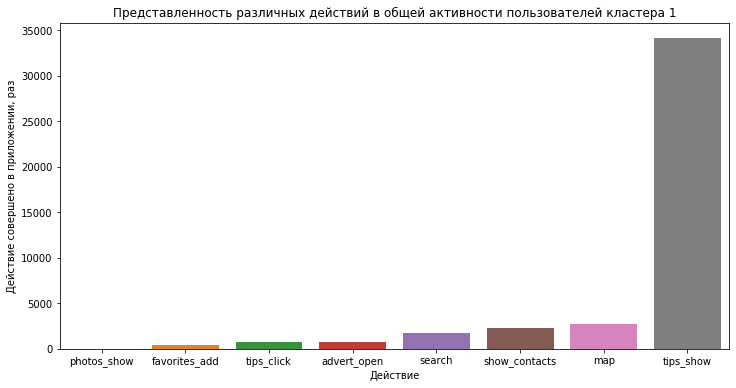

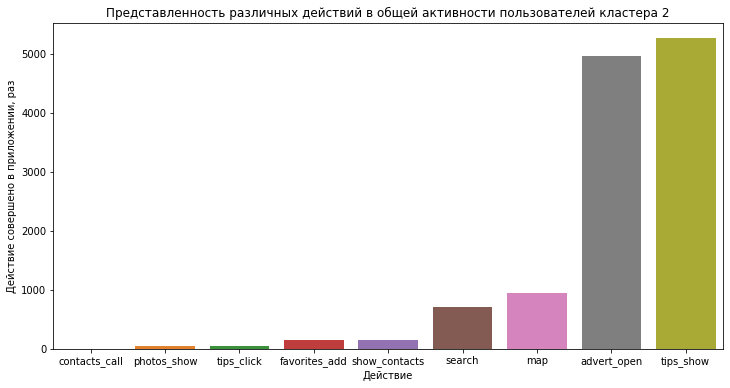

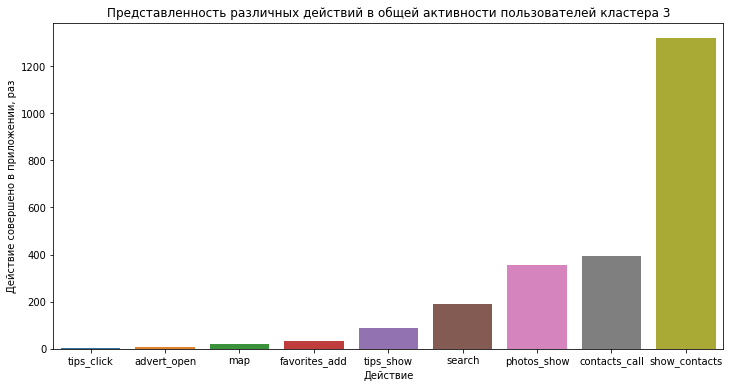

In [87]:
data = data.merge(clusters[['user_id', 'act_4']], on='user_id')
for cluster in [0,1,2,3]:  
    event_barplot = data.loc[data['act_4'] == cluster]['event_name'].value_counts().sort_values()
    plt.figure(figsize=(12,6))
    sns.barplot(x = event_barplot.index, y = event_barplot)
    plt.xlabel('Действие')
    plt.ylabel('Действие совершено в приложении, раз')
    plt.title('Представленность различных действий в общей активности пользователей кластера {}'.format(cluster))
    plt.show()

In [88]:
churn_and_target = users_metrics.groupby('user_id')[['is_inactive', 'is_target']].mean()
churn_and_target = pd.merge(churn_and_target, clusters[['user_id', 'act_4']], on='user_id')

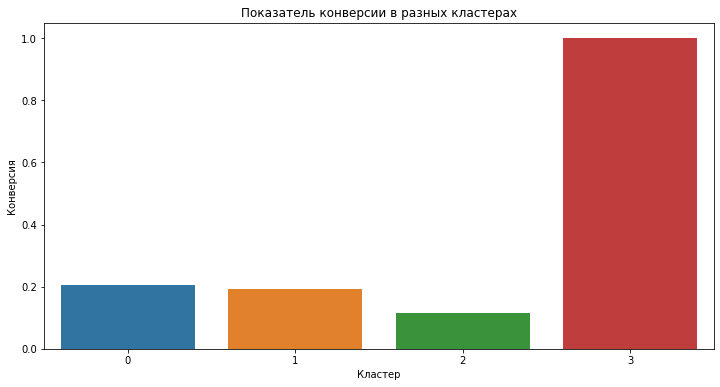

In [89]:
conversion_by_clusters = churn_and_target.groupby('act_4')['is_target'].mean()
plt.figure(figsize=(12,6))
sns.barplot(x = conversion_by_clusters.index, y = conversion_by_clusters)
plt.xlabel('Кластер')
plt.ylabel('Конверсия')
plt.title('Показатель конверсии в разных кластерах')
plt.show()

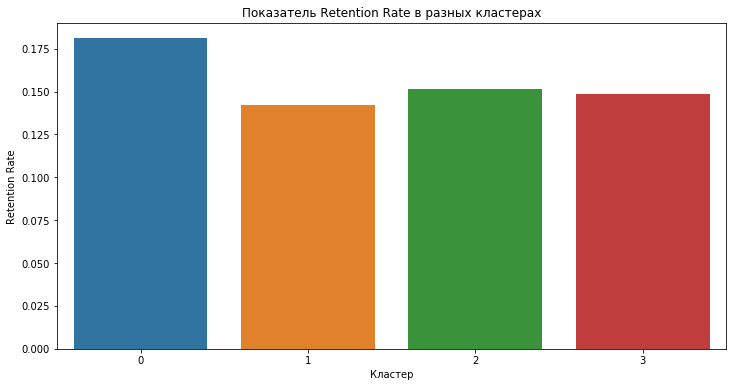

In [90]:
retention_by_clusters = 1 - churn_and_target.groupby('act_4')['is_inactive'].mean()
plt.figure(figsize=(12,6))
sns.barplot(x = retention_by_clusters.index, y = retention_by_clusters)
plt.xlabel('Кластер')
plt.ylabel('Retention Rate')
plt.title('Показатель Retention Rate в разных кластерах')
plt.show()

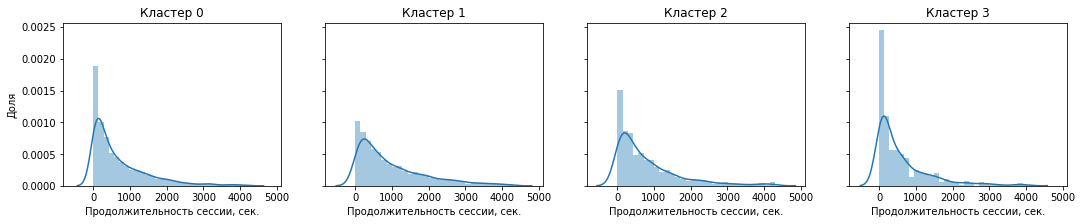

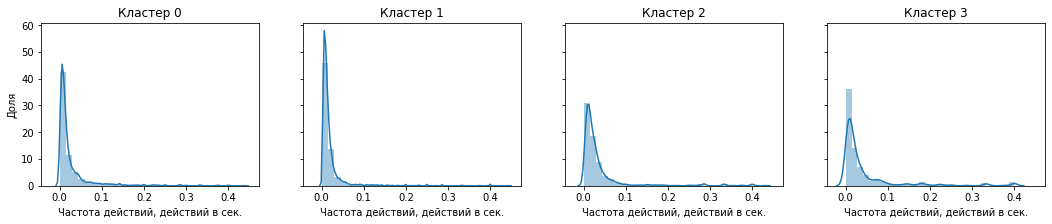

In [91]:
ftr_dct = {'session_duration' : 'Продолжительность сессии, сек.', 'actions_per_second' : 'Частота действий, действий в сек.'}
for ftr in ftr_dct.keys():
    f, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(18,3))
    rdf0 = users_metrics_clrd.loc[users_metrics_clrd['act_4'] == 0]
    sns.distplot(rdf0[ftr], ax = ax[0], bins=30)
    ax[0].set_title('Кластер 0')
    ax[0].set_ylabel('Доля')
    ax[0].set_xlabel(ftr_dct[ftr])
    rdf1 = users_metrics_clrd.loc[users_metrics_clrd['act_4'] == 1]
    sns.distplot(rdf1[ftr], ax = ax[1], bins=30)
    ax[1].set_title('Кластер 1')
    ax[1].set_xlabel(ftr_dct[ftr])
    rdf2 = users_metrics_clrd.loc[users_metrics_clrd['act_4'] == 2]
    sns.distplot(rdf2[ftr], ax = ax[2], bins=30)
    ax[2].set_title('Кластер 2')
    ax[2].set_xlabel(ftr_dct[ftr])
    rdf3 = users_metrics_clrd.loc[users_metrics_clrd['act_4'] == 3]
    sns.distplot(rdf3[ftr], ax = ax[3], bins=30)
    ax[3].set_title('Кластер 3')
    ax[3].set_xlabel(ftr_dct[ftr])

### Описание кластеров

В структуре активности кластера 0 преобладают действия "Поиск", "Показ фото" и "Добавление в избранное". У этих пользователей наблюдается самый высокий retention rate, средняя продолжительность сессий и конверсия, близкая к среднему значению по выборке в целом. К кластеру отнесены 1253 пользователя.

В структуре активности кластера 1 преобладают действия "Открытие объявления", "Открытие карты" и "Открытие справки". При этом у них наблюдается самая большая средняя продолжительность сессий, а также они реже остальных совершают в приложении целевое действие. Скорее всего, это новые пользователи, которые ищут не какой-то конкретный объект, а смотрят все возможные предложения. Это самый многочисленный кластер из выделенных, 2344 человек.

В структуре активности кластера 2 преобладают действия действия "Открытие справки", "Открытие объявления" и "Открытие карты", как и у кластера 1, но эти пользователи гораздо реже смотрят контакты, и для них наблюдается самая низкая конверсия среди всех кластеров. При этом у них высокая средняя продолжительность сессий и они совершают много действий в единицу времени и достаточно низкий показатель оттока. Скорее всего, это постоянные пользователи приложения, решающие в нем какие-то свои задачи. К этому кластеру отнесены 481 человек. 

В структуре активности кластера 3 пробладает целевое действие ("Показать контакты"), а также "Звонок контакту" и "Показать фотографии". Все пользователи, отнесенные к этому кластеру, совершили целевое действие, для них наблюдается самое маленькое среднее время сессии, они совершают больше всех действий в единицу времени, а также у них самый высокий показатель оттока. Скорее всего, это пользователи, заходящие в приложение с определенной целью, уже имея представление о том, что они хотят приобрести. В этом кластере 215 человек.

<a id='step4'></a>
## Статистический анализ

**Проверить гипотезу о значимости различий конверсии в зависимости от источника**

Формируем датафрейм под z-test (сравнение отношения долей на квантилях нормального распределения), это удобно делать с помощью crosstab

In [92]:
for_ztest = pd.merge(users_metrics.groupby('user_id')['is_target'].mean(), data[['user_id', 'source']].drop_duplicates(),
                     on='user_id')
for_ztest = pd.crosstab(index=for_ztest['source'], columns=for_ztest['is_target'], values=for_ztest['user_id'], aggfunc='count')

In [93]:
for_ztest.iloc[:, 0] = for_ztest.iloc[:, 0] + for_ztest.iloc[:, 1]

In [94]:
# Функция для удобного вывода описания результатов z-теста. На вход принимает датафрейм, два индекса строк датафрейма с информацией о
# количестве объектов в группах, название метрики и типа групп, значение уровня значимости альфа и коэффициент для 
# поправки на множественные сравнения Бонферрони.

def proportion_test(df, ix1, ix2, metric, grouptype, alpha = 0.05, bnf_coef=1):
    results = proportions_ztest(df.iloc[[ix1, ix2], 1], df.iloc[[ix1, ix2], 0])
    alpha = alpha
    if metric == 'conversion': 
        if grouptype == 'sources':
            print('Гипотеза H0: конверсия для пользователей, пришедших с источников', df.index[ix1], 'и', 
             df.index[ix2] + ',', 'одинакова')
        if grouptype == 'clusters':
            print('Гипотеза H0: конверсия для пользователей, принадлежащих к кластерам {} и {}, одинакова.'.format(df.index[ix1], df.index[ix2]))
    if metric == 'churn':
          print('Гипотеза H0: churn rate для пользователей, принадлежащих к кластерам {} и {}, одинаков.'.format(df.index[ix1], df.index[ix2]))
    print('')
    print('Уровень значимости alpha =', alpha)
    print('Коэффициент Бонферрони для поправки на множественные сравнения:', bnf_coef)
    print('')
    if results[1] < alpha / bnf_coef:
        print('Отвергаем гипотезу H0 на уровне значимости 0.05, значение статистики: {:.3f}, p_value: {:.3f}'.
             format(results[0], results[1]))
    else: 
        print('Не можем отвергнуть гипотезу H0 на уровне значимости 0.05, значение статистики: {:.3f}, p_value: {:.3f}'.
             format(results[0], results[1]))
    print('')
    print('Значение метрики для', df.index[ix1], '= {:.3f}'.format(df.iloc[ix1, 1] / df.iloc[ix1, 0]))
    print('Значение метрики для', df.index[ix2], '= {:.3f}'.format(df.iloc[ix2, 1] / df.iloc[ix2, 0]))
    print('')
    print('---')
    print('')

Вычисляем коэффициент поправки Бонферрони: у нас есть три сравнения для источника, плюс еще вполнедствии будем сравнивать четыре выделенных кластера по четырем метрикам. Для сравнения каждого кластера с каждым по одной метрике нужно провести C из 4 по 2 => 6 парных сравнений. То есть для сравнения всех кластеров по всем четырем метрикам потребуется 24 попарных сравнения. Плюс 3 сравнения источников, всего 27. Коэффициент для поправки Бонферрони будет равен 1/27. 

In [95]:
proportion_test(for_ztest, 0, 1, 'conversion', 'sources', 0.05, 27)

Гипотеза H0: конверсия для пользователей, пришедших с источников google и other, одинакова

Уровень значимости alpha = 0.05
Коэффициент Бонферрони для поправки на множественные сравнения: 27

Отвергаем гипотезу H0 на уровне значимости 0.05, значение статистики: 3.448, p_value: 0.001

Значение метрики для google = 0.244
Значение метрики для other = 0.185

---



In [96]:
proportion_test(for_ztest, 0, 2, 'conversion', 'sources', 0.05, 27)

Гипотеза H0: конверсия для пользователей, пришедших с источников google и yandex, одинакова

Уровень значимости alpha = 0.05
Коэффициент Бонферрони для поправки на множественные сравнения: 27

Не можем отвергнуть гипотезу H0 на уровне значимости 0.05, значение статистики: -0.222, p_value: 0.824

Значение метрики для google = 0.244
Значение метрики для yandex = 0.247

---



In [97]:
proportion_test(for_ztest, 1, 2, 'conversion', 'sources', 0.05, 27)

Гипотеза H0: конверсия для пользователей, пришедших с источников other и yandex, одинакова

Уровень значимости alpha = 0.05
Коэффициент Бонферрони для поправки на множественные сравнения: 27

Отвергаем гипотезу H0 на уровне значимости 0.05, значение статистики: -4.069, p_value: 0.000

Значение метрики для other = 0.185
Значение метрики для yandex = 0.247

---



**Проверить гипотезы о значимости различий между кластерами по исследуемым метрикам**

Подготавливаем данные для сравнения долей, используя crosstab

In [98]:
for_ztest_clusters = users_metrics.groupby('user_id')[['is_inactive', 'is_target', 'act_4']].mean()
for_ztest_clusters_is_inactive = pd.crosstab(index=for_ztest_clusters['act_4'], columns=for_ztest_clusters['is_inactive'], 
                                             values = for_ztest_clusters.index, aggfunc='count')
for_ztest_clusters_is_target = pd.crosstab(index=for_ztest_clusters['act_4'], columns=for_ztest_clusters['is_target'], 
                                             values = for_ztest_clusters.index, aggfunc='count').fillna(0).astype('int')

В первом столбце храним информацию о количестве пользователей в кластере в целом, во втором -- о количестве пользователей, совершивших целевое действие / прекративших пользоваться приложением

In [99]:
for_ztest_clusters_is_target.iloc[:, 0] = for_ztest_clusters_is_target.iloc[:, 0] + for_ztest_clusters_is_target.iloc[:, 1]
for_ztest_clusters_is_inactive.iloc[:, 0] = for_ztest_clusters_is_inactive.iloc[:, 0] + for_ztest_clusters_is_inactive.iloc[:, 1]

In [100]:
clusters_list = [0,1,2,3]

In [101]:
for i, j in combinations(clusters_list, 2):
    proportion_test(for_ztest_clusters_is_target, i, j, 'conversion', 'clusters', 0.05, 27)

Гипотеза H0: конверсия для пользователей, принадлежащих к кластерам 0 и 1, одинакова.

Уровень значимости alpha = 0.05
Коэффициент Бонферрони для поправки на множественные сравнения: 27

Не можем отвергнуть гипотезу H0 на уровне значимости 0.05, значение статистики: 0.820, p_value: 0.412

Значение метрики для 0 = 0.205
Значение метрики для 1 = 0.194

---

Гипотеза H0: конверсия для пользователей, принадлежащих к кластерам 0 и 2, одинакова.

Уровень значимости alpha = 0.05
Коэффициент Бонферрони для поправки на множественные сравнения: 27

Отвергаем гипотезу H0 на уровне значимости 0.05, значение статистики: 4.405, p_value: 0.000

Значение метрики для 0 = 0.205
Значение метрики для 2 = 0.114

---

Гипотеза H0: конверсия для пользователей, принадлежащих к кластерам 0 и 3, одинакова.

Уровень значимости alpha = 0.05
Коэффициент Бонферрони для поправки на множественные сравнения: 27

Отвергаем гипотезу H0 на уровне значимости 0.05, значение статистики: -23.055, p_value: 0.000

Значение мет

In [102]:
for i, j in combinations(clusters_list, 2):
    proportion_test(for_ztest_clusters_is_inactive, i, j, 'churn', 'sources', 0.05, 27)

Гипотеза H0: churn rate для пользователей, принадлежащих к кластерам 0 и 1, одинаков.

Уровень значимости alpha = 0.05
Коэффициент Бонферрони для поправки на множественные сравнения: 27

Не можем отвергнуть гипотезу H0 на уровне значимости 0.05, значение статистики: -3.082, p_value: 0.002

Значение метрики для 0 = 0.819
Значение метрики для 1 = 0.858

---

Гипотеза H0: churn rate для пользователей, принадлежащих к кластерам 0 и 2, одинаков.

Уровень значимости alpha = 0.05
Коэффициент Бонферрони для поправки на множественные сравнения: 27

Не можем отвергнуть гипотезу H0 на уровне значимости 0.05, значение статистики: -1.449, p_value: 0.147

Значение метрики для 0 = 0.819
Значение метрики для 2 = 0.848

---

Гипотеза H0: churn rate для пользователей, принадлежащих к кластерам 0 и 3, одинаков.

Уровень значимости alpha = 0.05
Коэффициент Бонферрони для поправки на множественные сравнения: 27

Не можем отвергнуть гипотезу H0 на уровне значимости 0.05, значение статистики: -1.149, p_value

In [103]:
users_metrics_clrd['session_duration'].describe()

count    7849.000000
mean      854.543254
std       873.783297
min         5.000000
25%       200.000000
50%       555.000000
75%      1240.000000
max      4301.000000
Name: session_duration, dtype: float64

In [104]:
users_metrics_clrd['actions_per_second'].describe()

count    7849.000000
mean        0.025745
std         0.047583
min         0.000939
25%         0.006711
50%         0.011913
75%         0.022989
max         0.444444
Name: actions_per_second, dtype: float64

Для количественных показателей видим, что оба распределения, даже на очищенных от самых экстремальных выбросов данных, все равно имеют тяжелый правый хвост и плохо описываются средним (среднее значительно больше медианы), то, что данные распределены не нормально, видно на глаз и без Шапиро-Уилко. Поэтому используем непараметрический критерий Манна-Уитни. 

In [105]:
# Функция для удобного вывода результатов теста Манна-Уитни, устроена похоже на функцию для z-теста.

def u_test_description(i, j, feature, bnf=1):
    first_sample = users_metrics_clrd.loc[users_metrics_clrd['act_4'] == i][feature]
    second_sample = users_metrics_clrd.loc[users_metrics_clrd['act_4'] == j][feature]
    results = mannwhitneyu(first_sample, second_sample)
    print('Сравнение метрики', feature, 'для кластеров {} и {}.'.format(i,j))
    print('')
    print('Гипотеза H0: значение метрики в двух кластерах не отличается.')
    print('Уровень значимости alpha = 0.05')
    print('Коэффициент поправки на множественные сравнения Бонферрони = {:.0f}.'.format(bnf))
    print('')
    if results[1] < 0.05 / bnf:
        print('Отвергаем гипотезу H0 на уровне значимости 0.05, значение метрики в двух кластерах отличается.')
    else:
        print('Не можем отвергнуть гипотезу H0 на уровне значимости 0.05, значение метрики в двух кластерах не отличается.')
    print('Значение статистики: {:.3f}, значение p-value: {:.3f}.'.format(results[0], results[1]))
    print('Медианное значение признака для кластера {} = {:.3f}'.format(i, np.median(first_sample)))
    print('Медианное значение признака для кластера {} = {:.3f}'.format(j, np.median(second_sample)))
    print('')
    print('---')
    print('')

In [106]:
for i, j in combinations(clusters_list, 2):
    u_test_description(i, j, 'session_duration', bnf=27)

Сравнение метрики session_duration для кластеров 0 и 1.

Гипотеза H0: значение метрики в двух кластерах не отличается.
Уровень значимости alpha = 0.05
Коэффициент поправки на множественные сравнения Бонферрони = 27.

Отвергаем гипотезу H0 на уровне значимости 0.05, значение метрики в двух кластерах отличается.
Значение статистики: 3966392.000, значение p-value: 0.000.
Медианное значение признака для кластера 0 = 408.000
Медианное значение признака для кластера 1 = 674.000

---

Сравнение метрики session_duration для кластеров 0 и 2.

Гипотеза H0: значение метрики в двух кластерах не отличается.
Уровень значимости alpha = 0.05
Коэффициент поправки на множественные сравнения Бонферрони = 27.

Отвергаем гипотезу H0 на уровне значимости 0.05, значение метрики в двух кластерах отличается.
Значение статистики: 1029274.500, значение p-value: 0.000.
Медианное значение признака для кластера 0 = 408.000
Медианное значение признака для кластера 2 = 527.000

---

Сравнение метрики session_duration

In [107]:
for i, j in combinations(clusters_list, 2):
    u_test_description(i, j, 'actions_per_second', bnf=27)

Сравнение метрики actions_per_second для кластеров 0 и 1.

Гипотеза H0: значение метрики в двух кластерах не отличается.
Уровень значимости alpha = 0.05
Коэффициент поправки на множественные сравнения Бонферрони = 27.

Отвергаем гипотезу H0 на уровне значимости 0.05, значение метрики в двух кластерах отличается.
Значение статистики: 4781655.000, значение p-value: 0.001.
Медианное значение признака для кластера 0 = 0.012
Медианное значение признака для кластера 1 = 0.011

---

Сравнение метрики actions_per_second для кластеров 0 и 2.

Гипотеза H0: значение метрики в двух кластерах не отличается.
Уровень значимости alpha = 0.05
Коэффициент поправки на множественные сравнения Бонферрони = 27.

Отвергаем гипотезу H0 на уровне значимости 0.05, значение метрики в двух кластерах отличается.
Значение статистики: 870862.500, значение p-value: 0.000.
Медианное значение признака для кластера 0 = 0.012
Медианное значение признака для кластера 2 = 0.019

---

Сравнение метрики actions_per_second дл

### Выводы по статистическому анализу

1. Сравнение источников. Пользователи, пришедшие с других источников (значение признака 'other'), значимо реже совершают целевое действие (конверсия 0.185), чем пользователи, пришедшие из Yandex'a или Google. Те, в свою очередь, совершают целевое действие одинаково часто (конверсия 0.245 и 0.247 соответственно). 

2. Сравнение кластеров. Единственная метрика, по которой не обнаруживается значимых отличий между кластерами, это churn/retention rate. По всем остальным метрикам почти все кластеры значимо попарно отличаются друг от друга, что дает дополнительные основания полагать, что кластеризация выделила группы пользователей, характеризующиеся важными для бизнеса параметрами и поведенческими паттернами. 

**Значения метрик для кластеров.** 

Конверсия:

* кластер 0: 0.205.
* кластер 1: 0.194.
* кластер 2: 0.114.
* кластер 3: 1.

Retention Rate (1 - Churn Rate):

* кластер 0: 0.395.
* кластер 1: 0.360.
* кластер 2: 0.362.
* кластер 3: 0.335.

Продолжительность сессии (медианные значения, в секундах):

* кластер 0: 416.
* кластер 1: 678.
* кластер 2: 537.
* кластер 3: 318.

Частота действий (медианные значения, количество действий в секунду):

* кластер 0: 0.011.
* кластер 1: 0.011.
* кластер 2: 0.018.
* кластер 3: 0.015.

<a id='step5'></a>
## Описание результатов и выводы

**Статистический анализ источников.** Пользователи, пришедшие из других источников (значение признака 'other'), значимо реже совершают целевое действие (конверсия 0.185), чем пользователи, пришедшие из Yandex'a или Google. Те, в свою очередь, совершают целевое действие одинаково часто (конверсия 0.245 и 0.247 соответственно). 

**Выделение и сравнение кластеров.** В результате кластерного анализа пользователей на основании различных признаков, самым контрастным в плане целевых метрик оказалось разделение пользователей на четыре кластера в зависимости от совершаемых ими в приложении действий. Выделенные кластеры значимо отличаются друг от друга по всем метрикам, кроме Retention Rate, для которого значимые различия обнаруживаются только для одной пары кластеров (0 и 3). По всем остальным метрикам почти все кластеры попарно значимо отличаются друг от друга, кроме одного случая: различия между кластерами 0 и 1 по метрикам "Конверсия" и "Частота действий" статистически незначимы.

**Описание кластеров**

*Кластер 0*, 29% всех пользователей. В структуре активности пользователей этого кластера преобладают действия "Показать фото", "Поиск" и "Добавить в избранное". Скорее всего, это постоянные, опытные пользователи приложения, они тратят в приложении достаточно мало времени, не пользуются справкой, и для них характерны сравнительно высокие показатели конверсии и retention rate. 

*Кластер 1*, 55% всех пользователей. В структуре активности пользователей этого кластера преобладают действие "Показать справку". Видимо, это новые пользователи приложения, незнакомые с ним, и поэтому для них характерна самая большая медианная продолжительность сессии, низкая частота действий, при этом они заинтересованы в использовании приложения и для них характерна достаточно высокая конверсия. *Рекомендации*. Для улучшения retention rate и конверсии этого кластера имеет смысл провести usability-анализ приложения на неопытных пользователях и выяснить, с какими сложностями они сталкиваются во время начала работы с приложением. 

*Кластер 2*, 11% всех пользователей. Активность этих пользователей в приложении похожа на активность пользователей кластера 1, здесь также преобладают действия "Показать справку" и "Карта". Но пользователи этого кластера, как правило, проводят в приложении гораздо меньше времени, совершают в целом больше действий, но реже совершают целевое действие. Скорее всего, это также новые пользователи приложения, но перед которыми при использовании приложения не стоит определенной цели. *Рекомендации*. Для улучшения конверсии пользователей этого кластера может подойти предложение им поучаствовать в промо-кампании, вывод специальных предложений и условий, которые помогли бы заинтересовать их в дальнейшем использовании приложения

*Кластер 3*, 5% всех пользователей. В структуре активности пользователей этого кластера преобладает целевое действие, а также "Вызов контакта" и "Показ фото". Для кластера наблюдается самая высокая, стопроцентная, конверсия, и одновременно самые низкие показатели Retention Rate и продолжительности сессии. Скорее всего, это пользователи зашедшие в приложение по внешней ссылке, заранее зная, какое предложение они хотят приобрести. *Рекомендации*. Точка роста этого кластера -- retention rate, стоит попытаться вернуть его пользователей в приложение маркетинговыми рассылками и специальными предложениями. 

<h4><center>Сравнительная таблица метрик в зависимости от кластера</center></h4>

| Кластер | Конверсия | Retention Rate | Продолжительность сессии | Частота действий | Доля от всех пользователей |
| --- | --- | --- | --- | --- | --- |
| 0 | 0.205 | 0.181 | 408 | 0.011 | 0.29 |
| 1 | 0.194 | 0.142 | 674 | 0.011 | 0.55 |
| 2 | 0.114 | 0.152 | 527 | 0.019 | 0.11 |
| 3 | 1 | 0.149 | 310 | 0.016 | 0.05 |